In [ ]:
# install dependencies
!pip3 install gym --upgrade
!pip3 install pyglet
!pip3 install Box2D
!pip3 install box2d-py
!pip3 install gym[Box_2D]
!pip3 install gym[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 KB 14.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827651 sha256=49a14e00335d16719f7c04e4b99b31a858779bd01562e1b9849a86041c52bc05
  Stored in directory: /root/.cache/pip/wheels/17/79/65/7afedc162d858b02708a3b8f7a6dd5b1000dcd5b0f894f7cc1
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.0/831.0 KB 33.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/pu

In [ ]:
import torch

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# enviroment
import gym

env = gym.make('LunarLander-v2')
state_size = env.observation_space.shape[0] #8 #TODO: find observation size
action_size = env.action_space.n #4 #TODO: find action size

In [ ]:
# experience replay
import random
import numpy as np
from collections import namedtuple, deque

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))


class ExperienceReplay():
    def __init__(self, capacity) -> None:
        self.memory = deque([], maxlen=capacity)

    def store_trans(self, s, a, sp, r, done):
        # TODO: store new transition in memory
        self.memory.append(Transition(s, a, sp, r, done))

    def sample(self, batch_size):
        # TODO: take RANDOM sample from memory
        samples = random.sample(self.memory, batch_size)

        states      = [s.state      for s in samples]
        actions     = [s.action      for s in samples]
        rewards     = [s.reward      for s in samples]
        next_states = [s.next_state      for s in samples]
        dones       = [s.done      for s in samples]

        return (states, actions, next_states, rewards, dones)

    def __len__(self):
        return len(self.memory)

In [ ]:
# DQN
import torch.nn as nn
import torch.nn.functional as F

class DeepQNetwork(nn.Module):
    def __init__(self, state_size, action_size) -> None:
        super(DeepQNetwork, self).__init__()
        # TODO: define the architecture
        # NOTE: input=observation/state, output=action
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.output = nn.Linear(128, action_size)
        pass

    def forward(self, x):
        # TODO: forward propagation
        # NOTE: use ReLu for activation function in all layers
        # NOTE: last layer has no activation function (predict action)
        fc1 = F.relu(self.fc1(x))
        fc2 = F.relu(self.fc2(fc1))
        out = self.output(fc2)
        return out

## DQN

In [ ]:
# DQN agent
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class DQNAgent():
    # NOTE: DON'T change initial values
    def __init__(self, state_size, action_size, batch_size,
                 gamma=0.99, buffer_size=25000, alpha=1e-4):
        # network parameter
        self.state_size = state_size
        self.action_size = action_size

        # hyperparameters
        self.batch_size = batch_size
        self.gamma = gamma

        # experience replay
        self.experience_replay = ExperienceReplay(buffer_size)

        # network
        self.value_net = DeepQNetwork(state_size, action_size).to(device)

        # optimizer
        # TODO: create adam for optimizing network's parameter (learning rate=alpha)
        self.optimizer = optim.Adam(self.value_net.parameters(), lr = alpha)

    def take_action(self, state, eps=0.0):
        # TODO: take action using e-greedy policy
        # NOTE: takes action using the greedy policy with a probability of 1−𝜖 and a random action with a probability of 𝜖
        state = torch.from_numpy(np.array(state)).reshape((1, 8)).float().to(device)
        self.value_net.eval()
        with torch.no_grad():
          action_values = self.value_net(state)

        # e-greedy
        if np.random.random() > eps:
          action = np.argmax(action_values.cpu().data.numpy())
        else:
          action = np.random.choice(self.action_size)

        return action


    def update_params(self):
        if len(self.experience_replay) < self.batch_size:
            return
        # transition batch
        batch = Transition(*self.experience_replay.sample(self.batch_size))

        state_batch = torch.from_numpy(np.vstack(batch.state)).float().to(device)
        action_batch = torch.tensor(np.vstack(batch.action)).long().to(device)
        next_state_batch = torch.from_numpy(np.vstack(batch.next_state)).float().to(device)
        reward_batch = torch.tensor(np.vstack(batch.reward)).float().to(device)
        done_batch = torch.tensor(np.vstack(batch.done)).to(device)

        # calculate loss w.r.t DQN algorithm
        self.value_net.train()
        # STEP1
        # TODO: compute the expected Q values [y]
        Q_preds_curr_state = self.value_net(state_batch)
        Q_preds = Q_preds_curr_state.gather(dim=1, index=action_batch)

        # STEP2
        # TODO: compute Q values [Q(s_t, a)]
        Q_preds_next_state = self.value_net(next_state_batch)
        Q_targets = reward_batch + (self.gamma * Q_preds_next_state.data.max(1)[0].unsqueeze(1) * (~done_batch))

        # STEP3
        # TODO: compute mse loss
        criterion = nn.MSELoss()
        loss = criterion(Q_preds, Q_targets)

        # TODO: optimize the model
        # NOTE: DON'T forget to set the gradients to zeros
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def save(self, fname):
        torch.save(self.value_net.state_dict(), './output/' + fname + '.pth')

    def load(self, fname, device):
        self.value_net.load_state_dict(fname).to(device)

In [ ]:
n_episodes = 250
eps = 1.0
eps_decay_rate = 0.97
eps_end = 0.01
batch_size = 128

In [ ]:
# training phase

# TODO: create agent
agent = DQNAgent(state_size = state_size, action_size = action_size, batch_size = batch_size)

crs = np.zeros(n_episodes) # cummulative rewards
crs_recent = deque(maxlen=25) # recent cummulative rewards
regret = np.zeros(n_episodes) # regrets for episodes

# training loop
for i_episode in range(1, n_episodes+1):
    # TODO: initialize the environment and state
    state, _ = env.reset()
    done = 0
    cr = 0 # episode cummulative rewards
    while not done:
      # TODO: select and perform an action
      action = agent.take_action(state, eps)
      next_state, reward, done, truncated, _ = env.step(action)
      done = done or truncated

      # TODO: store transition in experience replay
      agent.experience_replay.store_trans(state, action, next_state, reward, done)

      # TODO: update agent
      agent.update_params()

      # TODO: update current state and episode cummulative rewards
      cr += reward
      state = next_state

    # TODO: decay epsilon
    eps = max(eps * eps_decay_rate, eps_end)

    # TODO: update current cummulative rewards and recent cummulative rewards
    crs[i_episode - 1] = cr
    crs_recent.append(cr)

    # calculating and saving regret for episode
    regret[i_episode - 1] = np.mean(crs[: i_episode - 1]) - cr



    # TODO: save agent every 50 episodes
    if(i_episode % 50 == 0):
      agent.save(f'checkpoint{batch_size}_{i_episode}')
    # print logs
    print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps), end="")
    if i_episode % 25 == 0:
        print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps))

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode 25	Average Reward: -198.75	Epsilon: 0.47
Episode 50	Average Reward: -190.75	Epsilon: 0.22
Episode 75	Average Reward: -128.48	Epsilon: 0.10
Episode 100	Average Reward: -103.04	Epsilon: 0.05
Episode 125	Average Reward: -137.05	Epsilon: 0.02
Episode 148	Average Reward: -229.84	Epsilon: 0.01

KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt
plt.plot(crs)
plt.xlabel('Episode')
plt.ylabel('CRS')
plt.title(f'for {n_episodes} episodes, batch size: {batch_size}')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.plot(regret)
plt.xlabel('Episode')
plt.ylabel('Regret')
plt.title(f'for {n_episodes} episodes, batch size: {batch_size}')
plt.show()

In [ ]:
# downloading checkpoints
!zip -r ./dq_b64_checkpoints.zip ./output/checkpoint64_*

  adding: output/checkpoint64_100.pth (deflated 8%)
  adding: output/checkpoint64_150.pth (deflated 8%)
  adding: output/checkpoint64_200.pth (deflated 8%)
  adding: output/checkpoint64_250.pth (deflated 8%)
  adding: output/checkpoint64_50.pth (deflated 8%)


In [ ]:
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob
!pip install moviepy
import moviepy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import cv2
import os

def to_video(agent, name, model_dir):
  env = gym.make('LunarLander-v2', render_mode = 'rgb_array')
  agent.value_net.load_state_dict(torch.load(model_dir))
  video_dir = f'video/{name}.avi'

  state, _ = env.reset()
  frame = env.render()
  height, width, layers = frame.shape
  video = cv2.VideoWriter(video_dir, 0, 50, (width, height)) #it is 50 fps output!

  done = False
  trunc = False
  while not (done or trunc):
      action = agent.take_action(state)
      state, reward, done, trunc, _ = env.step(action)
      frame = env.render()
      video.write(frame)

  env.close()
  cv2.destroyAllWindows()
  video.release()

In [ ]:
# best batch_size = 64
for i in range(50, 251, 50):
  agent = DQNAgent(state_size=8, action_size=4, batch_size = 64)
  to_video(agent, f'DQN-b64-ep{i}', f'./output/checkpoint64_{i}.pth')

In [ ]:
# minimizing videos and make zip file to download
!ffmpeg -i ./video/DQN-b64-ep50.avi ./video/DQN-b64-ep50.mp4
!ffmpeg -i ./video/DQN-b64-ep100.avi ./video/DQN-b64-ep100.mp4
!ffmpeg -i ./video/DQN-b64-ep150.avi ./video/DQN-b64-ep150.mp4
!ffmpeg -i ./video/DQN-b64-ep200.avi ./video/DQN-b64-ep200.mp4
!ffmpeg -i ./video/DQN-b64-ep250.avi ./video/DQN-b64-ep250.mp4
!rm ./video/*.avi
!zip -r ./DQN-videos.zip ./video

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

## DDQN

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class DDQNAgent():
    # NOTE: DON'T change initial values
    def __init__(self, state_size, action_size, batch_size,
                 gamma=0.99, buffer_size=25000, alpha=1e-4):
        # network parameter
        self.state_size = state_size
        self.action_size = action_size

        # hyperparameters
        self.batch_size = batch_size
        self.gamma = gamma

        # experience replay
        self.experience_replay = ExperienceReplay(buffer_size)

        # network
        self.value_net = DeepQNetwork(state_size, action_size).to(device)
        self.target_value_net = DeepQNetwork(state_size, action_size).to(device)
        self.update_target_network()

        # optimizer
        # TODO: create adam for optimizing network's parameter (learning rate=alpha)
        self.optimizer = optim.Adam(self.value_net.parameters(), lr = alpha)

    def take_action(self, state, eps=0.0):
        # TODO: take action using e-greedy policy
        # NOTE: takes action using the greedy policy with a probability of 1−𝜖 and a random action with a probability of 𝜖
        state = torch.from_numpy(np.array(state)).reshape((1, 8)).float().to(device)
        self.value_net.eval()
        with torch.no_grad():
          action_values = self.value_net(state)
        # e-greedy
        if np.random.random() > eps:
          action = np.argmax(action_values.cpu().data.numpy())
        else:
          action = np.random.choice(self.action_size)

        return action


    def update_params(self):
        if len(self.experience_replay) < self.batch_size:
            return
        # transition batch
        batch = Transition(*self.experience_replay.sample(self.batch_size))

        state_batch = torch.from_numpy(np.vstack(batch.state)).float().to(device)
        action_batch = torch.tensor(np.vstack(batch.action)).long().to(device)
        next_state_batch = torch.from_numpy(np.vstack(batch.next_state)).float().to(device)
        reward_batch = torch.tensor(np.vstack(batch.reward)).float().to(device)
        done_batch = torch.tensor(np.vstack(batch.done)).to(device)

        # calculate loss w.r.t DQN algorithm
        self.value_net.train()
        # STEP1
        # TODO: compute the expected Q values [y]
        Q_preds_curr_state = self.value_net(state_batch)
        Q_preds = Q_preds_curr_state.gather(dim=1, index=action_batch)

        # STEP2
        # TODO: compute Q values [Q(s_t, a)]
        self.target_value_net.eval()
        with torch.no_grad():
          Q_preds_next_state = self.target_value_net(next_state_batch)
        Q_targets = reward_batch + (self.gamma * Q_preds_next_state.data.max(1)[0].unsqueeze(1) * (~done_batch))

        # STEP3
        # TODO: compute mse loss
        criterion = nn.MSELoss()
        loss = criterion(Q_preds, Q_targets)

        # TODO: optimize the model
        # NOTE: DON'T forget to set the gradients to zeros
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
        # TODO: copy main network parameters to target network parameters
        for target_value_net_w, value_net_w in zip(self.target_value_net.parameters(), self.value_net.parameters()):
          target_value_net_w.data.copy_(value_net_w.data)

    def save(self, fname):
        torch.save(self.value_net.state_dict(), './output/' + fname + '.pth')

    def load(self, fname, device):
        self.value_net.load_state_dict(fname).to(device)

In [ ]:
n_episodes = 250
eps = 1.0
eps_decay_rate = 0.97
eps_end = 0.01
batch_size = 128

In [ ]:
# training phase

# TODO: create agent
# best batch was 64
agent = DDQNAgent(state_size = state_size, action_size = action_size, batch_size = batch_size)

crs = np.zeros(n_episodes) # cummulative rewards
crs_recent = deque(maxlen=25) # recent cummulative rewards
regret = np.zeros(n_episodes) # regrets

# training loop
for i_episode in range(1, n_episodes+1):
    # TODO: initialize the environment and state
    state, _ = env.reset()
    done = 0
    cr = 0 # episode cummulative rewards
    while not done:
        # TODO: select and perform an action
        action = agent.take_action(state, eps)
        next_state, reward, done, truncated, _ = env.step(action)
        # finished or out of games bound!
        done = done or truncated

        # TODO: store transition in experience replay
        agent.experience_replay.store_trans(state, action, next_state, reward, done)

        # TODO: update agent
        agent.update_params()

        # TODO: update current state and episode cummulative rewards
        cr += reward
        state = next_state

    # updating target network
    agent.update_target_network()

    # TODO: decay epsilon
    eps = max(eps * eps_decay_rate, eps_end)

    # TODO: update current cummulative rewards and recent cummulative rewards
    crs[i_episode - 1] = cr
    crs_recent.append(cr)

    # calculating and saving regret for episode
    regret[i_episode - 1] = np.mean(crs[: i_episode - 1]) - cr



    # TODO: save agent every 50 episodes
   # if(i_episode % 50 == 0):
      #agent.save(f'DDcheckpoint{batch_size}_{i_episode}')
    # print logs
    print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps), end="")
    if i_episode % 25 == 0:
        print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps))

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode 25	Average Reward: -213.40	Epsilon: 0.47
Episode 50	Average Reward: -98.19	Epsilon: 0.22
Episode 75	Average Reward: -36.14	Epsilon: 0.10
Episode 100	Average Reward: -70.50	Epsilon: 0.05
Episode 125	Average Reward: -58.77	Epsilon: 0.02
Episode 150	Average Reward: -23.33	Epsilon: 0.01
Episode 175	Average Reward: 18.91	Epsilon: 0.01
Episode 200	Average Reward: 48.10	Epsilon: 0.01
Episode 225	Average Reward: 1.26	Epsilon: 0.01
Episode 250	Average Reward: 15.38	Epsilon: 0.01


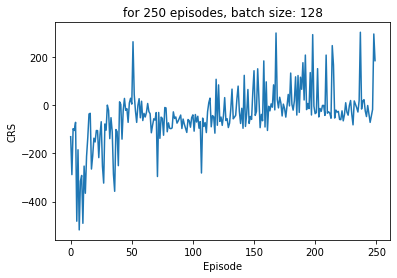

In [ ]:
import matplotlib.pyplot as plt
plt.plot(crs)
plt.xlabel('Episode')
plt.ylabel('CRS')
plt.title(f'for {n_episodes} episodes, batch size: {batch_size}')
plt.show()

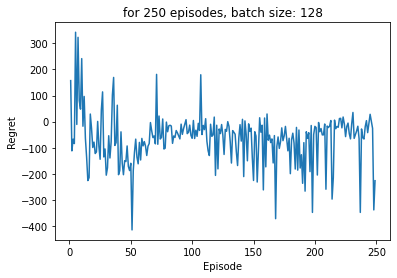

In [ ]:
import matplotlib.pyplot as plt
plt.plot(regret)
plt.xlabel('Episode')
plt.ylabel('Regret')
plt.title(f'for {n_episodes} episodes, batch size: {batch_size}')
plt.show()

In [ ]:
# downloading checkpoints
!zip -r ./ddq_b64_checkpoints.zip ./output/DDcheckpoint64_*

  adding: output/DDcheckpoint64_100.pth (deflated 9%)
  adding: output/DDcheckpoint64_150.pth (deflated 9%)
  adding: output/DDcheckpoint64_200.pth (deflated 8%)
  adding: output/DDcheckpoint64_250.pth (deflated 8%)
  adding: output/DDcheckpoint64_50.pth (deflated 9%)


In [ ]:
# ** Run to_video Block First! **
# best batch_size = 64
for i in range(50, 251, 50):
  agent = DDQNAgent(state_size=8, action_size=4, batch_size = 64)
  to_video(agent, f'DDQN-b64-ep{i}', f'./output/DDcheckpoint64_{i}.pth')

In [ ]:
# minimizing videos and make zip file to download
!ffmpeg -i ./video/DDQN-b64-ep50.avi ./video/DDQN-b64-ep50.mp4
!ffmpeg -i ./video/DDQN-b64-ep100.avi ./video/DDQN-b64-ep100.mp4
!ffmpeg -i ./video/DDQN-b64-ep150.avi ./video/DDQN-b64-ep150.mp4
!ffmpeg -i ./video/DDQN-b64-ep200.avi ./video/DDQN-b64-ep200.mp4
!ffmpeg -i ./video/DDQN-b64-ep250.avi ./video/DDQN-b64-ep250.mp4
!rm ./video/*.avi
!zip -r ./DDQN-videos.zip ./video

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e